# Text Clustering and Classification 
___
### Project Scope
Clustering and classifying texts using paragraphs from various sources of literature.   
Unsupervised model results will be evaluated against actual authorship.  
Unsupervised feature generation from texts to classify by Author.

### Data
The following pieces of literature were used in this project:

* The Adventures of Sherlock Holmes - Arthur Conan Doyle
* English traits - Ralph Waldo Emerson
* Conspiracy Theory to Explain all Other Conspiracy Theories - Soren Greenwood
* The Science of Right - Immanuel Kant
* Endymion - John Keats
* AUTOBIOGRAPHY - Thomas Jefferson
* The Mini Mart (DMZ Eyes) - Andy Thomas
* TERMINATOR 2: JUDGMENT DAY - James Cameron & William Wisher 
* Adventures of Huckleberry Finn - Mark Twain
* The Picture of Dorian Gray - Oscar Wilde


In [2]:
import numpy as np
import pandas as pd
import nltk
import os
from pathlib import Path
from nltk.corpus import PlaintextCorpusReader
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, Normalizer
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import make_pipeline
import scipy
from sklearn.decomposition import TruncatedSVD, PCA
import spacy
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
sns.set(font_scale=1.25)
sns.set_style('white')

%matplotlib inline 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Loren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Gather and Organize Data
Here we'll create a corpus of the text files and read them by paragraph, with assosciated author labels.

In [383]:
# Create list of files
files = os.listdir('texts')

In [384]:
# Print file list
print(files)

['cameron-t2.txt', 'doyle-adventures-380.txt', 'emerson-english-230.txt', 'greenwood-2001.txt', 'jefferson-autobio.txt', 'kant-science-146.txt', 'keats-endymion-484.txt', 'thomas-minimart.txt', 'twain-adventures-27.txt', 'wilde-picture-615.txt']


In [385]:
# Create corpus from files
corpus_root = r'..\unit_4\texts'
texts = PlaintextCorpusReader(corpus_root, '.*')
texts.fileids()

['cameron-t2.txt',
 'doyle-adventures-380.txt',
 'emerson-english-230.txt',
 'greenwood-2001.txt',
 'jefferson-autobio.txt',
 'kant-science-146.txt',
 'keats-endymion-484.txt',
 'thomas-minimart.txt',
 'twain-adventures-27.txt',
 'wilde-picture-615.txt']

In [386]:
# Create Author labels for each book
labels = []
for file in files:
    author = re.search(r'^\w+', file).group()
    labels.append([file, author])

In [387]:
labels

[['cameron-t2.txt', 'cameron'],
 ['doyle-adventures-380.txt', 'doyle'],
 ['emerson-english-230.txt', 'emerson'],
 ['greenwood-2001.txt', 'greenwood'],
 ['jefferson-autobio.txt', 'jefferson'],
 ['kant-science-146.txt', 'kant'],
 ['keats-endymion-484.txt', 'keats'],
 ['thomas-minimart.txt', 'thomas'],
 ['twain-adventures-27.txt', 'twain'],
 ['wilde-picture-615.txt', 'wilde']]

In [388]:
# Read corpus in by paragraph, and create list with author label
para_list = []
joined_paras = []
for book in labels:
    paragraphs = texts.paras(book[0])
    for paragraph in paragraphs:
        para = paragraph[0]
        para_list.append([' '.join(para), book[1]])
    print(book)

['cameron-t2.txt', 'cameron']
['doyle-adventures-380.txt', 'doyle']
['emerson-english-230.txt', 'emerson']
['greenwood-2001.txt', 'greenwood']
['jefferson-autobio.txt', 'jefferson']
['kant-science-146.txt', 'kant']
['keats-endymion-484.txt', 'keats']
['thomas-minimart.txt', 'thomas']
['twain-adventures-27.txt', 'twain']
['wilde-picture-615.txt', 'wilde']


# Text Cleaning
Some headers have been manually removed from the files. The body of the text will need to be cleaned before features are made. However, before that we'll look at the length of the paragraphs. Short paragraphs which don't contain a lot of text will be dropped as they won't contain much information. 

In [389]:
#Display mean paragraph length
para_len = []
for i in para_list:
    para_len.append(len(i[0]))

np.mean(para_len)

77.12120573355818

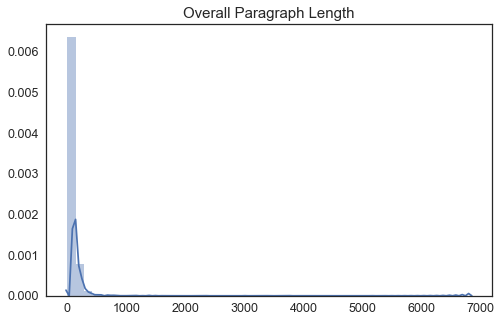

In [390]:
#Plot distribution of paragraph length
plt.figure(figsize=(8,5))
sns.distplot(para_len)
plt.title('Overall Paragraph Length')

plt.show()

In [391]:
# Make dataframe and rename columns
df = pd.DataFrame(para_list)
df.columns = ['paragraph', 'author']
df['length'] = para_len

In [392]:
# display shape of df
df.shape

(9488, 3)

In [393]:
# create list of author names
author_list = df['author'].unique()
print(author_list)

['cameron' 'doyle' 'emerson' 'greenwood' 'jefferson' 'kant' 'keats'
 'thomas' 'twain' 'wilde']


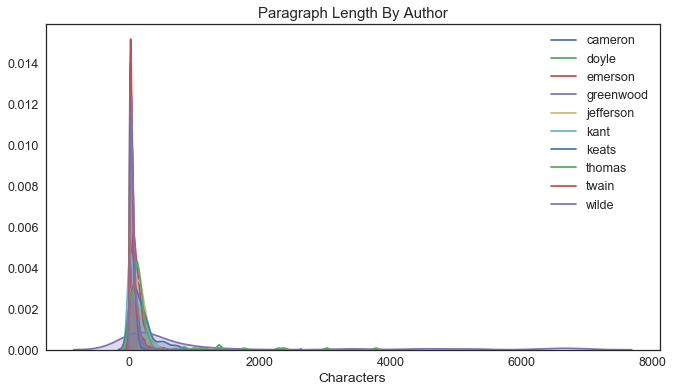

In [394]:
# plot distribution of paragraph length by author
plt.figure(figsize=(11,6))

for author in author_list:
    sns.kdeplot(df['length'][df['author']== author], shade=True, label=author)

plt.title('Paragraph Length By Author')
plt.xlabel('Characters')
plt.show()

##### Short paragraphs will be dropped since they don't contain much information.

In [395]:
# display new shape after dropping short paragraphs
df1 = df.drop(df[df['length'] < 200].index).reset_index(drop=True)
#df1 = df1.drop(df1[df1['length'] > 600].index).reset_index(drop=True)
#df1 = df
df1.shape

(588, 3)

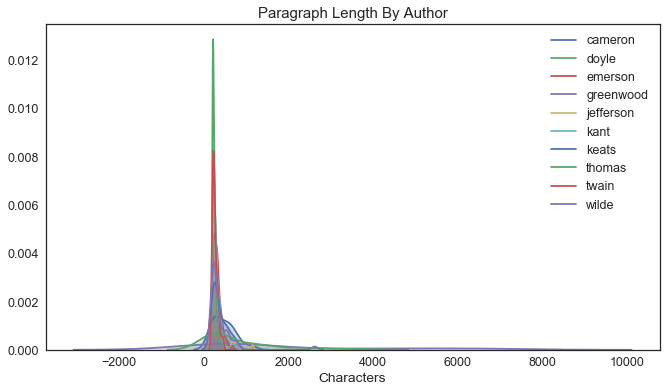

In [396]:
# plot distribution of paragraph length by author after dropping short paragraphs
plt.figure(figsize=(11,6))

for author in author_list:
    sns.kdeplot(df1['length'][df1['author']== author], shade=True, label=author)

plt.title('Paragraph Length By Author')
plt.xlabel('Characters')
plt.show()

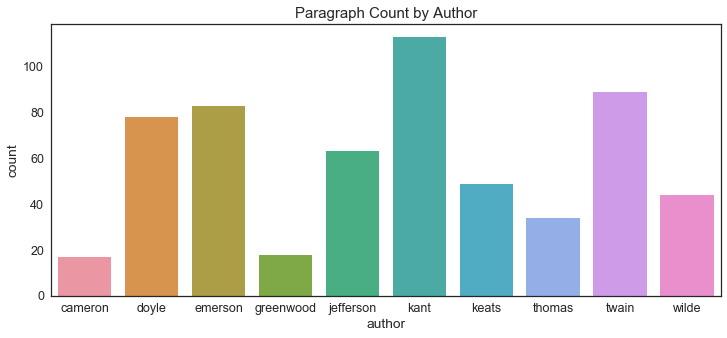

In [397]:
# Plot paragraph count by author
plt.figure(figsize=(12,5))
sns.countplot(x="author", data=df1);
plt.title('Paragraph Count by Author')

plt.show()

### Clean remaining paragraphs before feature engineering

In [398]:
# Define function to clean text
def text_cleaner(text):
    #remove double dash  
    text = re.sub(r'--',' ',text)
    #remove non alphabet chars
    text = re.sub(r"\s*[^A-Za-z]+\s*", " ", text)
    #remove numbers
    text = re.sub(r'\d+', '', text)
    #make lowercase
    text = text.lower()
    #remove punctuation
    text = re.sub(r'[^\w\s]','',text)
    #remove extra whitespace
    text = re.sub( '\s+', ' ', text ).strip()
    return text

In [399]:
# Apply text cleaner to paragraphs
df1['paragraph'] = df1['paragraph'].apply(text_cleaner)

In [400]:
# Display head
df1.head()

,paragraph,author,length
0,john is still in shock from the experience of ...,cameron,208
1,the terminator arnold scwarzenegger sarah conn...,cameron,1104
2,janet brady billy hank hooker bill lucas bob b...,cameron,247
3,art deparment assistant second assistant camer...,cameron,713
4,electricians boom operator james cox nicholas ...,cameron,274


### Lemmatize words

In [401]:
#Define function to lemmatize words
def make_lemma(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text)

In [402]:
# lemmatize Texts
df1['paragraph'] = df1['paragraph'].apply(make_lemma)

# Feature Engineering for clustering using TF-IDF

In [403]:
#Initialize a stop words list to be used in TF-IDF vectorizer. 
sw = stopwords.words('English')

###  Create TF-IDF feature vector for clustering

In [404]:
#Initialize vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        max_features=2500,
                       strip_accents='ascii',
                       analyzer='word',
                       stop_words=sw,
                        lowercase=False,
                        min_df=.1,
                       max_df=0.8)

In [405]:
#Create feature vector 
tfidf_features = tfidf.fit_transform(df1['paragraph'])
#Convert into array
features = tfidf_features.toarray()
#Create data frame of features
feature_names = tfidf.get_feature_names()
features_df = pd.DataFrame(features, columns=feature_names)

In [406]:
# Display head
features_df.head()

,one,right,upon,wa,would
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


# Modeling

In [407]:
# Standardize features
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss_features = ss.fit_transform(features_df)


In [408]:
# Define Y variable
Y = pd.Categorical(df1['author']).codes
# Create train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(ss_features, Y, test_size=.3, random_state=0)

In [409]:
# Display author codes in Y variable 
for author in author_list:
    index = df1[df1['author'] == author].index[0]
    print(author, 'code:', Y[index])

cameron code: 0
doyle code: 1
emerson code: 2
greenwood code: 3
jefferson code: 4
kant code: 5
keats code: 6
thomas code: 7
twain code: 8
wilde code: 9


#### Lets use feature reduction to visualize the actual labels. Actual model results will be based on full set of TF-IDF features.

In [410]:
# Use truncated SVD to reduce the features to 2 for visualization
SVD = TruncatedSVD(2)
X_train_svd = SVD.fit_transform(X_train)

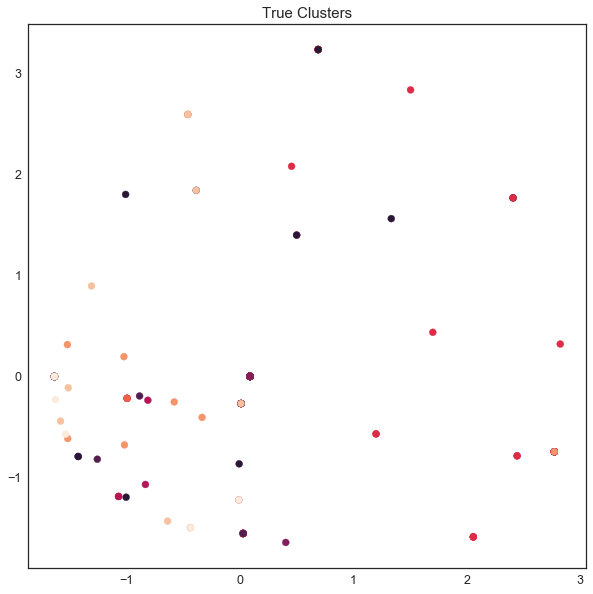

In [411]:
# Plot clusters
plt.figure(figsize=(10,10))

plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=Y_train)
plt.title('True Clusters')


plt.show()

## K-Means Clustering 

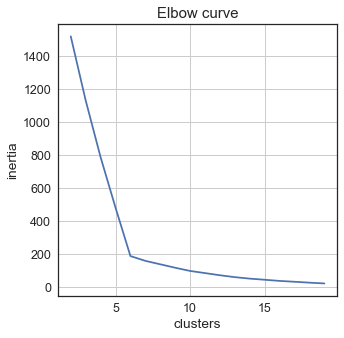

In [412]:
# Plot elbow curve to find ideal number of clusters
distortion = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    distortion.append(kmeans.inertia_)

fig = plt.figure(figsize=(5, 5))
plt.plot(range(2, 20), distortion)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel("clusters")
plt.ylabel('inertia')
plt.show()

In [413]:
#Initialize k-means model with 10 clusters for the 10 different authors. 
kcluster = KMeans(n_clusters=10, random_state=0)
kcluster.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [414]:
# get predicted clusters for training group
y_train_pred = kcluster.predict(X_train)

In [415]:
clusters = kcluster.cluster_centers_

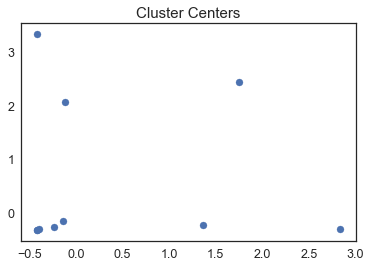

In [416]:
# plot cluster centers
plt.scatter(clusters[:,0], clusters[:,1])
plt.title('Cluster Centers')
plt.show()

In [417]:
# View counts for training clusters
np.unique(y_train_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 31, 199,  70,  24,  27,  31,   5,   8,  12,   4], dtype=int64))

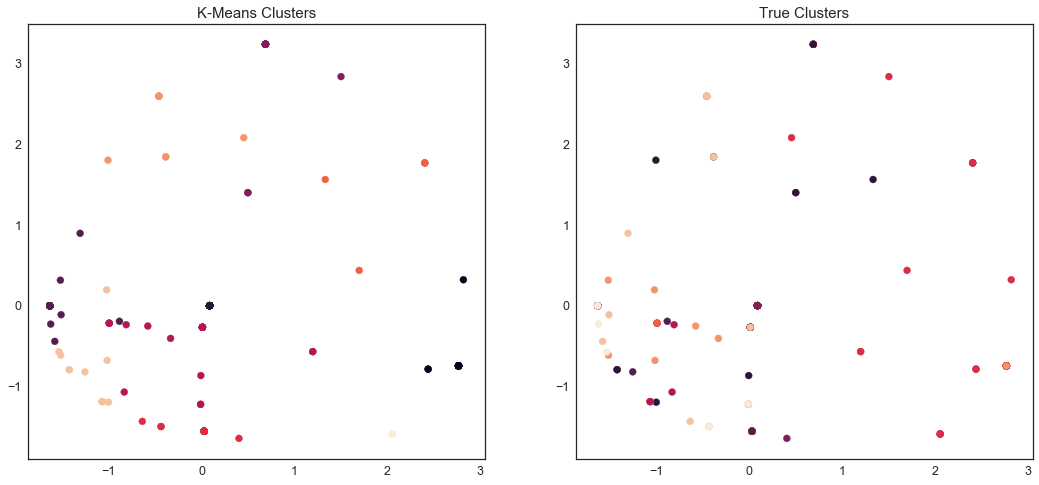

In [418]:
# Plot clusters, colored by k-means predicted clusters
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_pred)
plt.title('K-Means Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=Y_train)
plt.title('True Clusters')

plt.show()

In [419]:
# Display crosstab results of predicted clusters vs actual authors
print(pd.crosstab(Y_train, y_train_pred))
print('\nAdjusted Rand Index:', metrics.adjusted_rand_score(Y_train, y_train_pred))

col_0   0   1   2  3  4  5  6  7  8  9
row_0                                 
0       0  11   0  0  0  0  0  0  0  0
1       0  23  12  7  4  4  2  2  2  0
2       2  44   9  0  2  4  0  0  2  0
3       0  10   1  0  0  3  0  0  0  0
4       7  18   6  0  6  1  0  0  2  0
5      19  30   1  7  7  6  3  1  0  4
6       0  18   2  6  2  3  0  1  1  0
7       1  11   1  0  2  5  0  0  3  0
8       1  21  27  2  3  2  0  4  1  0
9       1  13  11  2  1  3  0  0  1  0

Adjusted Rand Index: 0.02149872407256758


###### K-means clustering performed very poorly in assigning observations to clusters by author. However as the elbow plot indicated, 10 is not the ideal number of clusters, let's see how k-means looks with 6 clusters.

In [420]:
#Initialize k-means model with 6 clusters based on the elbow plot. 
kcluster = KMeans(n_clusters=6, random_state=0)
kcluster.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [421]:
# get predicted clusters for training group
y_train_pred = kcluster.predict(X_train)

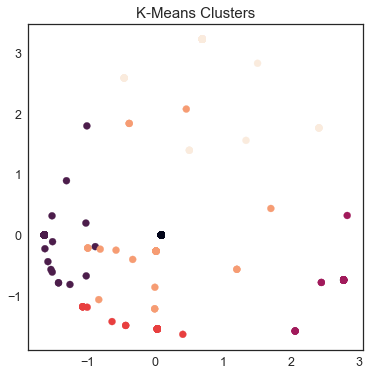

In [422]:
# Plot clusters, colored by k-means predicted clusters
plt.figure(figsize=(6,6))


plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_pred)
plt.title('K-Means Clusters')

plt.show()

# Spectral Clustering 

In [423]:
from sklearn.cluster import SpectralClustering

# 10 clusters
n_clusters=10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
y_train_pred = sc.fit_predict(X_train)

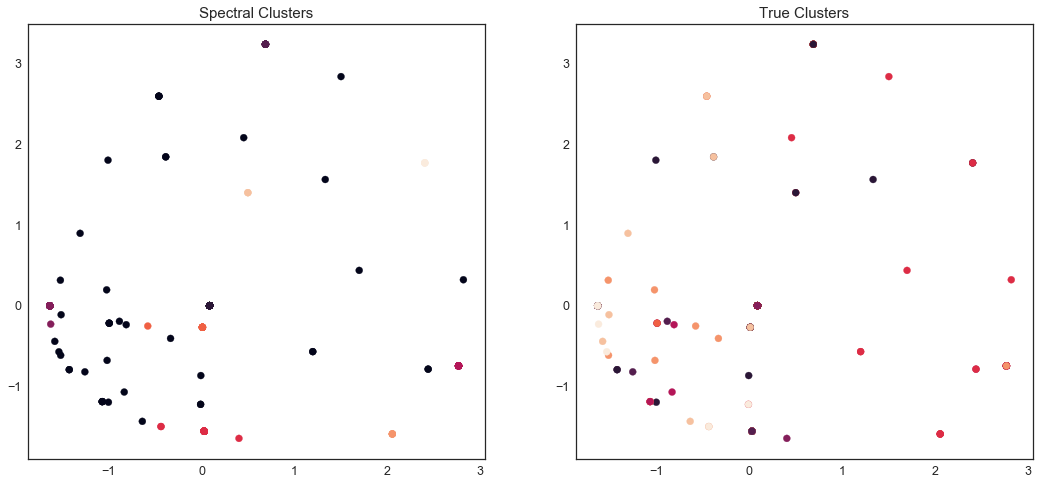

In [424]:
# Plot clusters, colored by spectral predicted clusters
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_pred)
plt.title('Spectral Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=Y_train)
plt.title('True Clusters')

plt.show()

In [425]:
print(pd.crosstab(Y_train,y_train_pred))
print('\nAdjusted Rand Index:', metrics.adjusted_rand_score(Y_train, y_train_pred))

col_0  0   1  2   3   4  5  6  7  8  9
row_0                                 
0      0  11  0   0   0  0  0  0  0  0
1      6  23  6  12   0  4  3  0  1  1
2      3  44  0   8   2  4  2  0  0  0
3      0  10  0   1   0  3  0  0  0  0
4      7  18  0   6   6  1  2  0  0  0
5      8  30  5   1  17  6  4  4  1  2
6      3  18  6   2   0  3  1  0  0  0
7      5  11  0   0   1  5  1  0  0  0
8      9  21  2  24   1  1  3  0  0  0
9      2  13  2  11   1  3  0  0  0  0

Adjusted Rand Index: 0.015712856977999637


# Affinity Propagation

In [426]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation().fit(X_train)

y_train_pred = af.predict(X_train)

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 364


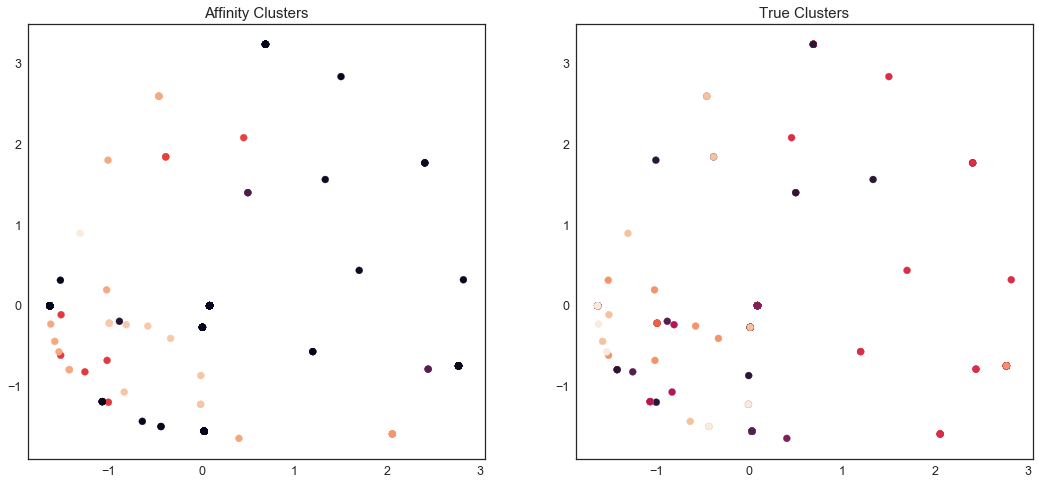

In [427]:
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_pred)
plt.title('Affinity Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=Y_train)
plt.title('True Clusters')

plt.show()

In [428]:
print(pd.crosstab(Y_train,y_train_pred))
print('\nAdjusted Rand Index:', metrics.adjusted_rand_score(Y_train, y_train_pred))

col_0  0    1    3    5    6    7    10   13   38   74   84   212  218  286  \
row_0                                                                         
0        0    0    0   11    0    0    0    0    0    0    0    0    0    0   
1        3   12    4   23    0    6    0    2    0    1    0    1    1    0   
2        2    8    4   44    0    0    2    0    1    0    0    1    0    0   
3        0    1    2   10    0    0    0    0    0    0    0    0    0    0   
4        2    6    1   18    2    0    6    0    0    0    1    0    0    0   
5        6    1    6   30    0    6   18    3    0    1    1    0    1    4   
6        1    2    3   18    1    6    0    0    0    0    0    0    0    0   
7        0    1    4   11    1    0    1    0    0    0    0    2    0    0   
8        3   24    1   21    2    2    1    0    0    0    0    1    1    0   
9        0   10    2   13    1    2    1    0    0    0    0    0    0    0   

col_0  298  300  302  326  329  363  
row_0        

#### The Adjusted Rand Index for all three clustering methods indicates that no method was better than randomly guessing. 

# Clustering using Bag of Words

In [429]:
bow = CountVectorizer(analyzer='word',ngram_range=(2,2), min_df=.1, max_df=.8, max_features=8000)

In [430]:
bow_features = bow.fit_transform(df1['paragraph'])
bow_features = bow_features.toarray()
bow_feature_names = bow.get_feature_names()
bow_features_df = pd.DataFrame(bow_features, columns=bow_feature_names)

In [431]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss_features = ss.fit_transform(bow_features_df)

In [432]:
Y = pd.Categorical(df1['author']).codes
# Create train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(ss_features, Y, test_size=.3, random_state=0)

In [433]:
SVD = TruncatedSVD(2)
X_train_svd = SVD.fit_transform(X_train)

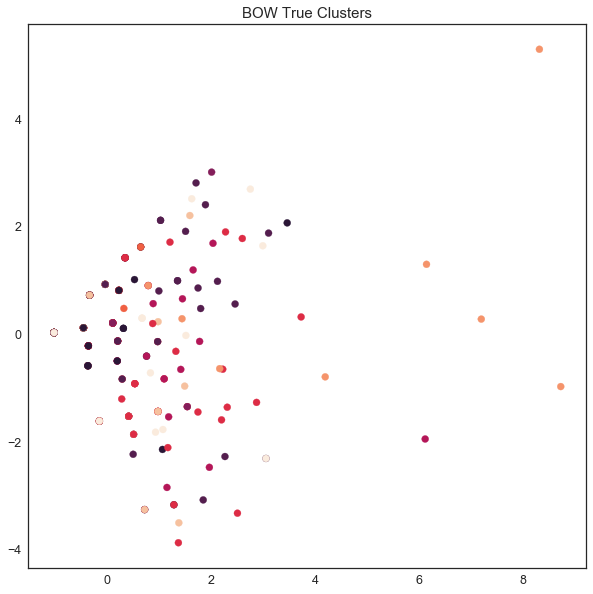

In [434]:
plt.figure(figsize=(10,10))

plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=Y_train)
plt.title('BOW True Clusters')


plt.show()

In both cases, using TFIDF and BOW, the text vectors for individual authors do not share enough common characteristics to be clustered together, as seen in the true cluster plots. This makes clustering by author a very challenging task. The models did however cluster the data, but it was based on features that were not author specific. 

# Unsupervised Feature Generation for Classification by Author

For the unsupervised feature generation, we'll start with a new TF-IDF feature vector with more features.

In [435]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        max_features=5000,
                       strip_accents='ascii',
                       analyzer='word',
                       stop_words=sw,
                        lowercase=False)

In [436]:
tfidf_features2 = tfidf.fit_transform(df1['paragraph'])
features = tfidf_features2.toarray()
feature_names = tfidf.get_feature_names()
features_df = pd.DataFrame(features, columns=feature_names)

In [437]:
features_df.head()

,abel,ability,able,able assert,abolished,abolishing,absence,absolute,absolutely,abstain,...,yield,york,young,young man,young men,youth,zen,zero,zion,zodiac
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.056232,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [438]:
# Create train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(features_df, Y, test_size=.3, random_state=0)

In [439]:
# Use latent semantic analysis to reduce the features to 500
svd= TruncatedSVD(500)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_train)
X_test_lsa = lsa.fit_transform(X_test)

## Logistic Regression

In [440]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()

lr.fit(X_train, Y_train)
print('Score on training data:', lr.score(X_train, Y_train))
print('Score on test data:', lr.score(X_test, Y_test))

Score on training data: 0.9416058394160584
Score on test data: 0.4971751412429379


In [441]:
cross_val_score(lr, X_train, Y_train, cv=10)

array([0.55319149, 0.53333333, 0.56818182, 0.56097561, 0.6       ,
       0.55      , 0.58974359, 0.58974359, 0.63157895, 0.52631579])

## Logistic Regression with ridge regularization

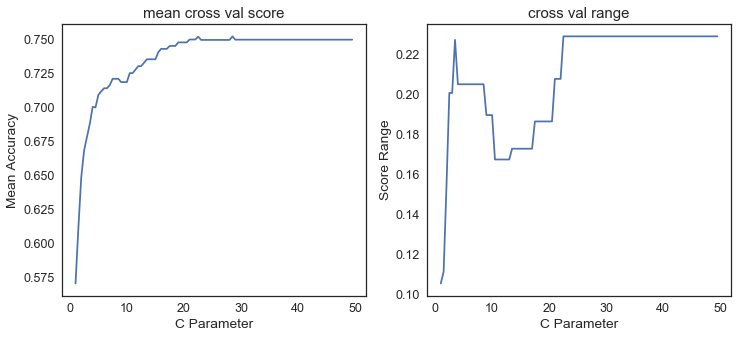

In [460]:
# tune l2 regularization
param_tune = []
#for i in [0.01, 0.02, 0.05, 0.07, 0.09, 0.1, 0.5, 1, 1.1, 1.2, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]:
#for i in [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.01]:
for i in np.arange(1, 50, .5):    
    ridge = LogisticRegression(penalty='l2', C=i)
    ridge.fit(X_train, Y_train)
    score = cross_val_score(ridge, X_train, Y_train, cv=10)
    mean_score = score.mean()
    score_range = score.max() - score.min()
    param_tune.append([i, mean_score, score_range])

param_tune = pd.DataFrame(param_tune)
param_tune.columns = ['parameter', 'mean_score', 'score_range']

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(param_tune.parameter, param_tune.mean_score)
plt.title('mean cross val score')
plt.xlabel('C Parameter')
plt.ylabel('Mean Accuracy')

plt.subplot(1, 2, 2)
plt.plot(param_tune.parameter, param_tune.score_range)
plt.title('cross val range')
plt.xlabel('C Parameter')
plt.ylabel('Score Range')

plt.show()

In [462]:
param_tune

,parameter,mean_score,score_range
0,1.0,0.570306,0.105263
1,1.5,0.611294,0.111111
2,2.0,0.648406,0.153930
3,2.5,0.668255,0.200542
4,3.0,0.678223,0.200542
5,3.5,0.687887,0.227100
6,4.0,0.700437,0.204878
7,4.5,0.700000,0.204878
8,5.0,0.709256,0.204878
9,5.5,0.711887,0.204878


In [444]:
from sklearn.metrics import classification_report

ridge = LogisticRegression(penalty='l2', C=13)
ridge.fit(X_train, Y_train)

y_pred = ridge.predict(X_test)
print(classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.50      0.67         6
          1       0.49      0.77      0.60        22
          2       0.47      0.85      0.61        20
          3       1.00      0.50      0.67         4
          4       1.00      0.61      0.76        23
          5       0.90      1.00      0.95        35
          6       0.92      0.69      0.79        16
          7       1.00      0.45      0.62        11
          8       0.68      0.61      0.64        28
          9       0.83      0.42      0.56        12

avg / total       0.79      0.71      0.71       177



In [445]:
cross_val_score(ridge, X_train, Y_train, cv=10)

array([0.78723404, 0.62222222, 0.72727273, 0.7804878 , 0.7       ,
       0.7       , 0.76923077, 0.76923077, 0.78947368, 0.68421053])

# Gradient Boosting Classifier

In [448]:
from sklearn.ensemble import GradientBoostingClassifier

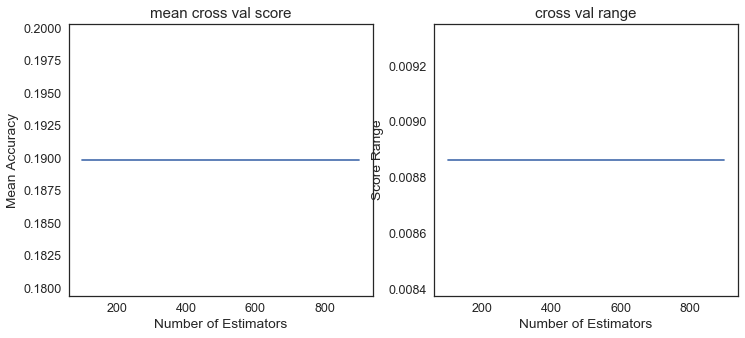

In [450]:
# tune n_estimators
param_tune = []
for i in np.arange(100, 1000, 100):
    
    boost = GradientBoostingClassifier(learning_rate=0.1, n_estimators=i, max_depth=6, min_samples_split=450, min_samples_leaf=42,max_features='sqrt',subsample=0.7)
    score = cross_val_score(boost, X_train, Y_train, cv=5)
    mean_score = score.mean()
    score_range = score.max() - score.min()
    param_tune.append([i, mean_score, score_range])

param_tune = pd.DataFrame(param_tune)
param_tune.columns = ['parameter', 'mean_score', 'score_range']

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(param_tune.parameter, param_tune.mean_score)
plt.title('mean cross val score')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy')

plt.subplot(1, 2, 2)
plt.plot(param_tune.parameter, param_tune.score_range)
plt.title('cross val range')
plt.xlabel('Number of Estimators')
plt.ylabel('Score Range')

plt.show()

Gradient boosting classifier is performing extremely poor based on tuning of number of estimators.

## Support Vector Machine

In [451]:
from sklearn.svm import SVC

svm = SVC(C=1,  kernel='rbf')

y_pred = svm.fit(X_train, Y_train).predict(X_test)

In [452]:
print('Score on training data:', svm.score(X_train, Y_train))
print('Score on test data:', svm.score(X_test, Y_test))

Score on training data: 0.1897810218978102
Score on test data: 0.1977401129943503


In [453]:
cross_val_score(svm, X_train, Y_train, cv=5)

array([0.18390805, 0.19047619, 0.19277108, 0.18987342, 0.19230769])

Support vector machine is also performing very poor.

## Naive Bayes

In [454]:
from sklearn.naive_bayes import MultinomialNB

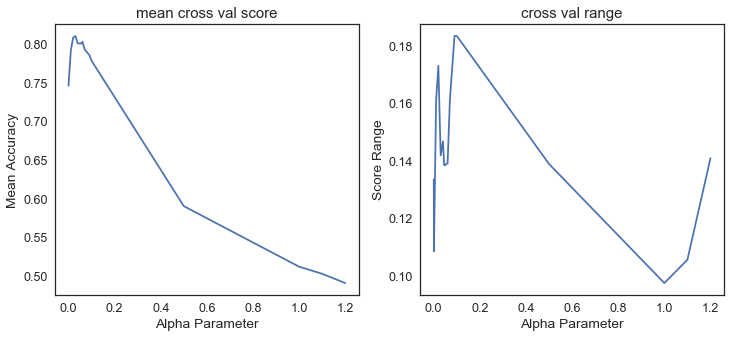

In [455]:
# tune alpha
param_tune = []
for i in [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07, 0.09, 0.1, 0.5, 1, 1.1, 1.2]:
#for i in [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.01]:
#for i in np.arange(1, 50, .5):    
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train, Y_train)
    score = cross_val_score(clf, X_train, Y_train, cv=10)
    mean_score = score.mean()
    score_range = score.max() - score.min()
    param_tune.append([i, mean_score, score_range])

param_tune = pd.DataFrame(param_tune)
param_tune.columns = ['parameter', 'mean_score', 'score_range']

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(param_tune.parameter, param_tune.mean_score)
plt.title('mean cross val score')
plt.xlabel('Alpha Parameter')
plt.ylabel('Mean Accuracy')

plt.subplot(1, 2, 2)
plt.plot(param_tune.parameter, param_tune.score_range)
plt.title('cross val range')
plt.xlabel('Alpha Parameter')
plt.ylabel('Score Range')

plt.show()

In [456]:
param_tune

,parameter,mean_score,score_range
0,0.0001,0.745998,0.133511
1,0.0010,0.751293,0.108511
2,0.0100,0.791377,0.160684
3,0.0200,0.808273,0.173077
4,0.0300,0.810414,0.141880
5,0.0400,0.800628,0.146795
6,0.0450,0.800794,0.138462
7,0.0500,0.800794,0.138462
8,0.0550,0.800483,0.139007
9,0.0600,0.802922,0.139007


In [457]:
clf = MultinomialNB(alpha=.03)
clf.fit(X_train, Y_train)

print('Score on training data:', clf.score(X_train, Y_train))
print('Score on test data:', clf.score(X_test, Y_test))

Score on training data: 1.0
Score on test data: 0.7740112994350282


In [458]:
cross_val_score(clf, X_train, Y_train, cv=10)

array([0.85106383, 0.75555556, 0.81818182, 0.7804878 , 0.775     ,
       0.775     , 0.8974359 , 0.84615385, 0.78947368, 0.81578947])

In [459]:
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.83      0.91         6
          1       0.64      0.73      0.68        22
          2       0.70      0.70      0.70        20
          3       1.00      0.75      0.86         4
          4       0.79      0.65      0.71        23
          5       0.89      0.97      0.93        35
          6       0.68      0.81      0.74        16
          7       0.75      0.82      0.78        11
          8       0.83      0.68      0.75        28
          9       0.69      0.75      0.72        12

avg / total       0.78      0.77      0.77       177



## Conclusion
You can see that out of the classifiers that were used, Naive Bayes performed the best with the unsupervised features that were created. With a mean cross-validation score of 0.81 and a cross-validation range of .1, it was significantly better than the second best, logistic regression with ridge regularization. Which had a cross-validation mean of 0.73 and a cross-validation range of 0.165.

Overall the clusters were not able to classify the texts by author. The plots of the true clusters show that the different authors are all interspersed and were therefore clustered by different characteristics that were not author specific.

The Naive Bayes model and the logistic regression with ridge regularization model both performed fairly decently at classifying the texts by author.

In this case the upside of using the supervised models to classify by author is that the labeled data informs the model of what relationship to be looking for. Conversely, the clusters require interpretation to determine what that relationship is, and in this case it wasn't the one that was being targeted.

For future studies, I would incorporate neural networks to generate features for improved clustering and modeling.